# Deep Learning w/ Python

## Home Assignment I. by Kristof Rabay - CNN

---

## Silent MNIST

<p><a href="https://commons.wikimedia.org/wiki/File:%D9%84%D8%BA%D8%A9_%D8%A7%D9%84%D8%A7%D8%B4%D8%A7%D8%B1%D8%A9_%D8%A7%D9%84%D8%A7%D9%85%D8%B1%D9%8A%D9%83%D9%8A%D8%A9.png#/media/File:لغة_الاشارة_الامريكية.png"><img src="./pics/exercises/silent_mnist.png" width=400></a><br>By <a href="//commons.wikimedia.org/w/index.php?title=User:Krzys_kurd&amp;action=edit&amp;redlink=1" class="new" title="User:Krzys kurd (page does not exist)">Krzys kurd</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24699115">Link</a></p>

### Description

Create a silent number detector using the different pictures taken of the signers hands. Your task is to create a neural network to solve this problem, using dense layers. You are free to use any kind of preprocessing or any kind of transformation on the data, and you can use any discussed methods.  
Your designed solution must be presented in a form of clean, structured and well commented code. Descriptions should include the designed network layouts and the reasoning behind the choices. The final results should be highlighted, saved ([tutorial](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)) and easily reproduceable.  
Creating parametrizable functions to dynamically generate networks is a plus.

### About the data

The pictures are already preprocessed and transformed into greyscale image matrices.  
The target variable is the value of the associated sign in one-hot encoded form.  
Both feature matrix and target vectors are available as numpy arrays and can be found in the `data/sign_language/` folder. You can read `.npy` numpy array files with the `np.load("path_to_file.npy")` function.

# Solution

## 1. Let's read in the data to work with

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd()

'C:\\Users\\Krisz\\Desktop\\ceu\\materials\\spring\\dl_py\\dlwp_assignments\\Deep-Learning-w-Python\\assignment_1_silent_MNIST'

In [3]:
os.chdir("../../../deep_learning/data/sign_language/")
os.listdir()

['model.png', 'references.md', 'X.npy', 'y.npy']

In [4]:
X = np.load("X.npy")
y = np.load("y.npy")

## 2. How does the data look like?

2062 images to train and to test with, respectively

X: 64x64 numpy arrays (1 color, 64 * 64 pixels)

y: 1x10 numpy arrays (10 possible outcomes)

In [5]:
X.shape, y.shape

((2062, 64, 64), (2062, 10))

In [6]:
X[:1], y[:1]

(array([[[0.47450978, 0.46274507, 0.45098037, ..., 0.50196075,
          0.5137255 , 0.52549016],
         [0.46666664, 0.45098037, 0.43921566, ..., 0.4980392 ,
          0.5098039 , 0.52156866],
         [0.45490193, 0.43921566, 0.42745095, ..., 0.49411762,
          0.50196075, 0.517647  ],
         ...,
         [0.4470588 , 0.4352941 , 0.4235294 , ..., 0.49019605,
          0.4980392 , 0.5058824 ],
         [0.45490193, 0.44313723, 0.43137252, ..., 0.4980392 ,
          0.5058824 , 0.5137255 ],
         [0.46274507, 0.45098037, 0.43921566, ..., 0.50196075,
          0.5098039 , 0.52156866]]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))

Let's visualize the 1st one to see the actual image!

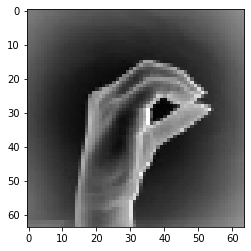

In [7]:
plt.imshow(np.squeeze(X[1]), cmap="gray")
plt.show()

## 3. Importing everything I'll be working with via the Keras API and scikit-learn

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras.regularizers import l1, l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [9]:
from sklearn.model_selection import train_test_split

## 4. Splitting the X and y to train-test sets

It's more important for the model to be generally 'good' (on lots of test datasets) rather than be great on only one dataset.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20202020)

Let's check if we still see images

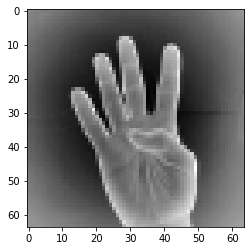

In [11]:
plt.imshow(X_train[0], cmap = 'gray')

In [12]:
X_train.shape, y_train.shape

((1649, 64, 64), (1649, 10))

Now we are training CNNs, so let's reshape the arrays with a color dimension (gray)

In [13]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

I turned the 2062 image arrays into 1649 train + 413 test arrays with 64 x 64 size and 1 color dimension

In [14]:
X_train.shape, X_test.shape

((1649, 64, 64, 1), (413, 64, 64, 1))

## 5. Setting up and fitting the model

In [15]:
input_shape = (64, 64, 1)
output_classes = y_train.shape[1] # have 10 classes to predict

#### Structure

- I'll build a CNN with Keras API
- I'll use 2 convolutional layers, max pooling after both, then a flatten layer and then 1 dense layer connected to the output layer
- I'll use a dropout layer for generalization - dropout rate will be set to 20%
- My output layer will be activated by softmax (due to >2 categories to predict)

#### Compilation

- Categorical Cross-Entropy will be used as a loss f(x) (output has been one-hot encoded)
- Adam will be leveraged for optimization (keeping default learning rate at 0.001)
- Will be monitoring Accuracy

#### Callbacks used

- I want to change / stop training once validation loss doesn't decrease further
1. Learning rate reduction - if for 5 consecutive epochs validation loss doesn't decrease, I'll decrease LR by 1/3
2. Early stopping metric - if for 10 consecutive epochs validation loss doesn't decrease, training stops

#### Validation

- Will be using 20% of train data as validation set (test is held out for final evaluation)

In [16]:
model = Sequential()

model.add(Conv2D(64, kernel_size = (3, 3), input_shape = input_shape, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, kernel_size = (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(256, activation = 'sigmoid'))

model.add(Dense(output_classes, activation = 'softmax'))


model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [17]:
callbacks = [PlotLossesKeras(),
             EarlyStopping(monitor = 'val_loss', patience = 10),
             ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 1/3)]

In [18]:
#plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 16)        4624      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)              

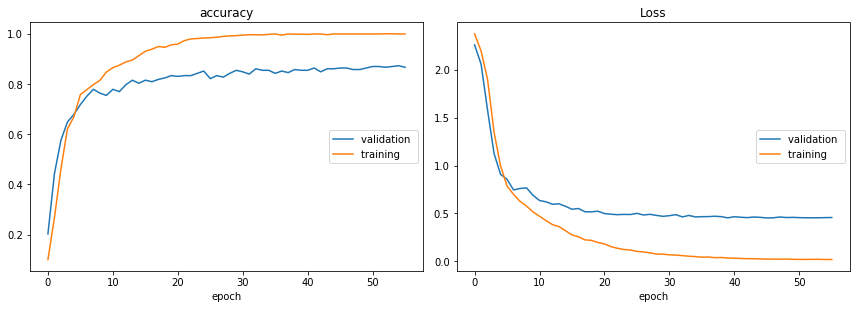

accuracy
	validation       	 (min:    0.203, max:    0.873, cur:    0.867)
	training         	 (min:    0.101, max:    1.000, cur:    0.999)
Loss
	validation       	 (min:    0.454, max:    2.260, cur:    0.458)
	training         	 (min:    0.020, max:    2.375, cur:    0.020)


In [19]:
model.fit(X_train, 
          y_train, 
          batch_size = 128, 
          epochs = 100, 
          validation_split = 0.2, 
          verbose = 1,
          callbacks = callbacks)

## 6. Evaluating on the test set

Train accuracy reached ~100%, while validation was around 87%. Test accuracy is ~90%, so generalization worked, the model seems to perform similarly on validational data sets. ~90% is a lot better than 80% of ANN, maybe a pre-trained model could go beyond 95% test acc too

In [21]:
test_acc = model.evaluate(X_test, y_test, verbose = 0)[1]
print("Accuracy on test set: ","{:.2%}".format(test_acc))

Accuracy on test set:  89.59%


## 7. Saving model

No need to re-train the model again

In [22]:
model.save("../../../dlwp_assignments/Deep-Learning-w-Python/assignment_1_silent_MNIST/silent_mnist_model_CNN.h5")

In [ ]:
# to load
# model = load_model("../../../assignment_1/silent_mnist_model.h5")

## 8. Transfer learning using ResNet50 model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20202020)

In [ ]:
X_train.shape, X_test.shape

Have to make the grayscale images seem like RGB 

In [ ]:
X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test = np.repeat(X_test[..., np.newaxis], 3, -1)

In [ ]:
from keras.applications import ResNet50

In [ ]:
transfer_model = Sequential()

base = ResNet50(include_top = False, input_shape = (64, 64, 3), weights = "imagenet")
base.trainable = False

transfer_model.add(base)

# ADD ...

In [ ]:
transfer_model.summary()